In [2]:
import numpy as np
import matplotlib.pyplot as plt

from new_fft import new_fft2, new_ifft
from pad import pad, adj_pad
from frac_fft import frac_fft


# Forward PPFFT

We first define the Pseudo-Polar FFT for the basically horizontal lines:

In [3]:
def ppfft_horizontal(a: np.ndarray) -> np.ndarray:
    """
    Pseudo-Polar Fast Fourier Transform on the basically horizontal lines.

    ## Parameters
    a : np.ndarray
        Input array of shape (n, n) where n is even.

    ## Returns
    y : np.ndarray
        Ouput array of shape (n+1, 2n+1).
    """
    n, _ = a.shape
    m = 2 * n + 1

    res = np.empty((n + 1, m), dtype=np.complex64)
    Id_hat = new_fft2(pad(a, new_shape=(n, m)))
    for k in range(m):
        q = Id_hat[:, k]
        ifft_q = new_ifft(q)
        pad_ifft_q = pad(ifft_q, (m,))
        frac_pad_ifft_q = frac_fft(pad_ifft_q, 2 * (k - n), n)
        adj_pad_frac_ifft_q = adj_pad(frac_pad_ifft_q, (n + 1,))
        res[:, k] = adj_pad_frac_ifft_q[::-1]

    return res


Here we define the coordinates of the horizontal lines. In the paper, they are given by (when $n$ is even):
$$
\left\{ \left(- \frac{2l}{n}k, k \right) \mid l \in \llbracket - \frac{n}{2}, \frac{n}{2} \rrbracket, \, k \in \llbracket -n, n \rrbracket \right\}
$$

In [4]:
def horizontal_lines(n: int):
    """
    Computes the positions of the basically horizontal lines of the pseudo-polar grid.

    ## Parameters
    n : int
        Size of the image whose PPFFT we want to compute.

    ## Returns
    coords : np.ndarray
        Array of shape (n+1, 2*n+1, 2). coords[..., 0] gives the x coordinates.

    ## See Also
    vertical_lines : Return the positions of the basically vertical lines of the pseudo-polar grid.
    """

    coords = np.empty(shape=(n + 1, 2 * n + 1, 2))

    for l in range(n + 1):
        for k in range(2 * n + 1):
            coords[l, k, 0] = -2 * (l - n//2) * (k - n) / n
            coords[l, k, 1] = k - n

    return coords


In [5]:
coords = horizontal_lines(10)


In [6]:
hori_x_coords = coords[..., 0]
hori_y_coords = coords[..., 1]


[]

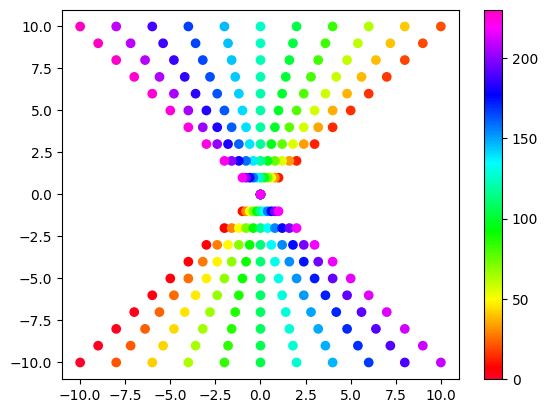

In [18]:
plt.scatter(hori_x_coords.flatten(), hori_y_coords.flatten(),
            c=np.arange(hori_x_coords.size), cmap='gist_rainbow')
plt.colorbar()
plt.plot()


In [7]:
n = 10
a = np.random.rand(n, n)
hori_ppfft = ppfft_horizontal(a)


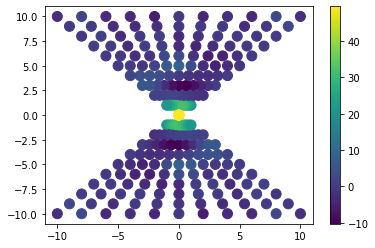

In [8]:
plt.scatter(hori_x_coords.flatten(), hori_y_coords.flatten(),
            c=hori_ppfft.real.flatten(), s=100)
plt.colorbar()
plt.show()


In order to check that the computed values are correct, we directly compute the Discrete Time Fourier Transform on the pseudo-polar grid:

In [9]:
def slow_DTFT(a, omega_x, omega_y, m):
    n, _ = a.shape
    u = np.arange(-n//2, n//2)
    v = np.arange(-n//2, n//2)
    return np.einsum("uv,u,v->", a, np.exp(-2j * np.pi * omega_x * u / m), np.exp(-2j * np.pi * omega_y * v / m))


In [10]:
true_hori_ppfft = np.empty(shape=(n + 1, 2 * n + 1), dtype=np.complex64)

for l in range(n + 1):
    for k in range(2 * n + 1):
        true_hori_ppfft[l, k] = slow_DTFT(a, hori_x_coords[l, k],
                                          hori_y_coords[l, k], 2 * n + 1)


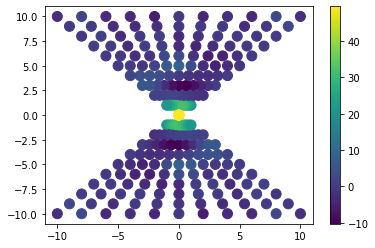

In [11]:
plt.scatter(hori_x_coords.flatten(), hori_y_coords.flatten(),
            c=true_hori_ppfft.real.flatten(), s=100)
plt.colorbar()
plt.show()


In [12]:
np.max(np.abs(true_hori_ppfft - hori_ppfft))


0.0

We also compute the values of the DTFT on a cartesian grid, to check that our new discretization makes sense.

In [13]:
cartesian_x = np.arange(-n, n+1)
cartesian_y = np.arange(-n, n+1)
xx, yy = np.meshgrid(cartesian_x, cartesian_y)


In [14]:
cartesian_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(
    np.pad(a, ((n//2, n//2 + 1), (n//2, n//2 + 1))))))


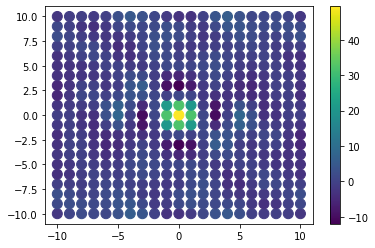

In [15]:
plt.scatter(xx.flatten(), yy.flatten(), c=cartesian_fft.real.flatten(), s=100)
plt.colorbar()
plt.show()


# Vertical lines

In [16]:
def ppfft_vertical(a: np.ndarray) -> np.ndarray:
    """
    Pseudo-Polar Fast Fourier Transform on the basically vertical lines.

    ## Parameters
    a : np.ndarray
        Input array of shape (n, n) where n is even.

    ## Returns
    y : np.ndarray
        Ouput array of shape (n+1, 2*n+1).

    ## See Also
    ppfft_horizontal : Return the PPFFT on the basically horizontal lines.
    """
    return ppfft_horizontal(a.T)


Here we define the coordinates of the vertical lines. In the paper, they are given by (when $n$ is even):
$$
\left\{ \left(k, - \frac{2l}{n}k \right) \mid l \in \llbracket - \frac{n}{2}, \frac{n}{2} \rrbracket, \, k \in \llbracket -n, n \rrbracket \right\}
$$

In [17]:
def vertical_lines(n: int):
    """
    Computes the positions of the basically vertical lines of the pseudo-polar grid.

    ## Parameters
    n : int
        Size of the image whose PPFFT we want to compute.

    ## Returns
    coords : np.ndarray
        Array of shape (n+1, 2*n+1, 2). coords[..., 0] gives the x coordinates.

    ## See Also
    horizontal_lines : Return the positions of the basically horizontal lines of the pseudo-polar grid.
    """

    coords = np.empty(shape=(n + 1, 2 * n + 1, 2))

    for l in range(n + 1):
        for k in range(2 * n + 1):
            coords[l, k, 0] = k - n
            coords[l, k, 1] = -2 * (l - n//2) * (k - n) / n

    return coords


In [18]:
vert_coords = vertical_lines(10)
vert_x_coords = vert_coords[..., 0]
vert_y_coords = vert_coords[..., 1]


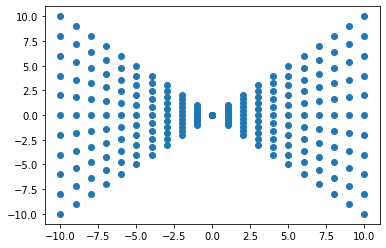

In [19]:
plt.scatter(vert_x_coords.flatten(), vert_y_coords.flatten())


In [20]:
vert_ppfft = ppfft_vertical(a)


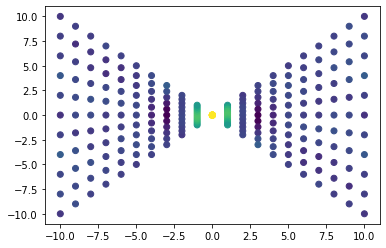

In [21]:
plt.scatter(vert_x_coords.flatten(), vert_y_coords.flatten(),
            c=vert_ppfft.real.flatten())


In [22]:
true_vert_ppfft = np.empty(shape=(n + 1, 2 * n + 1), dtype=np.complex64)

for l in range(n + 1):
    for k in range(2 * n + 1):
        true_vert_ppfft[l, k] = slow_DTFT(
            a, vert_x_coords[l, k], vert_y_coords[l, k], 2 * n + 1)


In [23]:
np.max(np.abs(true_vert_ppfft - vert_ppfft))


0.0

# Entire grid

In [24]:
x_coords = np.concatenate((hori_x_coords.flatten(), vert_x_coords.flatten()))
y_coords = np.concatenate((hori_y_coords.flatten(), vert_y_coords.flatten()))
ppfft = np.concatenate((hori_ppfft.flatten(), vert_ppfft.flatten()))


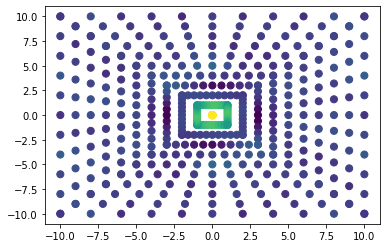

In [25]:
plt.scatter(x_coords, y_coords, c=ppfft.real, s=50)


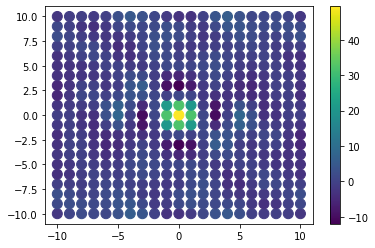

In [26]:
plt.scatter(xx.flatten(), yy.flatten(), c=cartesian_fft.real.flatten(), s=100)
plt.colorbar()
plt.show()
